# **Adaptive Prediction Sets (APS)**

### The Problem of Uncertainty in Machine Learning Predictions


Traditional ML models do not provide information about **uncertainty or reliabilty**. But that is **crucial** in critical applications, that are in need of **guaranteed coverage**.

An example for such application would be an autuonomous driving application. It is not enough to predict "It is a pedestrian", the application has **to be confident** about something on the road being "a pedestrian, cyclist or a traffic sign", to prevent serious concequences.


### Core Idea: Conformal Prediction

While traditional ML models only provide point predictions, APS provide prediction sets. 

Traditional: Model predicts "class 3"

APS: Model predicts "{2, 3, 5}" with 90% confidence

### Marginal Coverage

Marginal coverage provides a statistical guarantee.

$$\mathbb{P}[Y_{n+1} \in \hat{C}_{n,\alpha}(X_{n+1})] \geq 1-\alpha$$

Where: 
- $\mathbb{P}[\cdot]$: Probability operator
- $Y_{n+1}$: Unknown true label we want to predict
- $\hat{\mathcal{C}}_{n,\alpha}(\cdot)$: prediction set function that maps features
- $X_{n+1}$: Observed features of test point
- $1-\alpha$: Target probability of coverage

Let's look at a simple coverage test, where $\alpha=0.1$.

In [14]:
test_images = 10
alpha = 0.1
target_coverage = 1 - alpha

results = [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]  # 9 out of 10 correct

coverage = sum(results) / len(results)

print(f"Number of test images: {test_images}")
print(f"Target coverage: {target_coverage} (90%)")
print(f"Actual coverage: {coverage} ({coverage * 100}%)")
print(f"Coverage >= Target coverage: {coverage >= target_coverage}")
print(f"Calculation: {sum(results)} / {len(results)} = {coverage}")

Number of test images: 10
Target coverage: 0.9 (90%)
Actual coverage: 0.9 (90.0%)
Coverage >= Target coverage: True
Calculation: 9 / 10 = 0.9


### The APS Algorithm

Provides the Conformity Score:
$$ E(x,y,u;\hat{\pi}) = \min\{\tau \in [0,1] : y \in \mathcal{S}(x,u;\hat{\pi},\tau)\} $$

The conformity score measures the **minimum probability threshold** at which the true label would be included in the prediction set, quantifying how **"surprised"** the model is by the correct answer.

Following: A Simple APS Conformity Score implemented:

In [15]:
from typing import Any, Self

import numpy as np


def aps_conformity_score(_self: None, probabilities: np.ndarray, true_labels: np.ndarray) -> np.ndarray:
    """E(x,y,u;π̂) = min{τ ∈ [0,1] : y ∈ S(x,u;π̂,τ)}.

    Finds the minimum threshold τ at which the true class
    is included in the prediction set.
    """
    conformity_scores = []

    for true_label, probs in zip(true_labels, probabilities, strict=False):
        # descending
        sorted_indices = np.argsort(probs)[::-1]
        sorted_probs = probs[sorted_indices]

        cumulative_probs = np.cumsum(sorted_probs)

        true_class_pos = np.where(sorted_indices == true_label)[0][0]

        # score is cumulative prob up to the true class
        aps_score = cumulative_probs[true_class_pos]
        conformity_scores.append(aps_score)

    return np.array(conformity_scores)

Where inputs are probabilitites(model's predicted probabilities), true_labels.

For each sample, sort classes by probability and find the **cumulative probability at whih the true class is included**.

Low conformity score means the model is "surprised" by the true label.

Mathemathical Interpretation: The minimum probability threshold τ where the true class y would be included in the prediction set S(x,τ).

### APS implemented on Iris Dataset

1. Whats is the Iris Dataset? 
The Iris Dataset is a classical benchmark dataset, which contains 150 samples of the 3 different species (50 samples per species) of the iris flower. It is an ideal dataset to test and teach such algorithms through examples.

Heres an implementation of Iris and APS implemented:


In [16]:
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class BaseAPSImplementation:
    """base class for all APS methods."""

    def __init__(self, significance_level: float = 0.1, model: RandomForestClassifier | None = None) -> None:
        """Initializes APS system with given significance level."""
        self.significance_level = significance_level
        self.model = model or RandomForestClassifier(n_estimators=100, random_state=42)
        self.quantile = None
        self.calibration_scores = None

    def load_prepare_data(self, test_size: float = 0.2, calib_size: float = 0.25) -> tuple:
        """Load and split the Iris dataset."""
        iris = load_iris()
        x, y = iris.data, iris.target
        feature_names = iris.feature_names
        target_names = iris.target_names

        # Für Split-Conformal: Train/Calib/Test
        x_temp, x_test, y_temp, y_test = train_test_split(
            x,
            y,
            test_size=test_size,
            random_state=42,
            stratify=y,
        )
        x_train, x_calib, y_train, y_calib = train_test_split(
            x_temp,
            y_temp,
            test_size=calib_size,
            random_state=42,
            stratify=y_temp,
        )

        return x_train, x_calib, x_test, y_train, y_calib, y_test, feature_names, target_names

    def train_model(self, x_train: np.ndarray, y_train: np.ndarray) -> RandomForestClassifier:
        """Train base classifier."""
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(x_train, y_train)
        return self.model

    def aps_conformity_score(self, probabilities: np.ndarray, true_labels: np.ndarray) -> np.ndarray:
        """E(x,y,u;π̂) = min{τ ∈ [0,1] : y ∈ S(x,u;π̂,τ)}.

        Finds the minimum threshold τ at which the true class
        is included in the prediction set.
        """
        conformity_scores = []

        for true_label, probs in zip(true_labels, probabilities, strict=False):
            # descending
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]

            cumulative_probs = np.cumsum(sorted_probs)

            true_class_pos = np.where(sorted_indices == true_label)[0][0]

            # score is cumulative prob up to the true class
            aps_score = cumulative_probs[true_class_pos]
            conformity_scores.append(aps_score)

        return np.array(conformity_scores)

    def calculate_prediction_sets(self, probabilities: np.ndarray, tau: float) -> list[list[int]]:
        """Calculates prediction sets for for given threshold tau."""
        prediction_sets = []

        for probs in probabilities:
            sorted_indices = np.argsort(probs)[::-1]
            sorted_probs = probs[sorted_indices]
            cumulative_probs = np.cumsum(sorted_probs)

            prediction_set = []
            for i, (class_idx, cum_prob) in enumerate(zip(sorted_indices, cumulative_probs, strict=False)):
                if cum_prob <= tau or i == 0:
                    prediction_set.append(class_idx)
                else:
                    break

            prediction_sets.append(prediction_set)

        return prediction_sets

    def fit_aps(self, x_train: np.ndarray, y_train: np.ndarray, x_calib: np.ndarray, y_calib: np.ndarray) -> Self:
        """Trains model and calibrates APS."""
        # train model
        self.train_model(x_train, y_train)
        # calculate confirmity scoer on data
        calib_probs = self.model.predict_proba(x_calib)
        self.calibration_scores = self.aps_conformity_score(calib_probs, y_calib)

        # calculate quantile for set
        self.quantile = np.quantile(self.calibration_scores, self.significance_level)

        print("APS Calibration Complete:")
        print(f"  Significance level (a): {self.significance_level}")
        print(f"  Calibration quantile: {self.quantile:.3f}")
        print(f"  Target coverage: {1 - self.significance_level:.1%}")

        return self

    def predict_with_aps(self, x: np.ndarray) -> tuple[np.ndarray, list[list[int]], np.ndarray]:
        """Makes predictions with APS sets."""
        probabilities = self.model.predict_proba(x)
        point_predictions = self.model.predict(x)
        prediction_sets = self.calculate_prediction_sets(probabilities, self.quantile)
        aps_scores = self.aps_conformity_score(probabilities, point_predictions)

        return point_predictions, prediction_sets, aps_scores

    def evaluate_aps(self, x_test: np.ndarray, y_test: np.ndarray) -> dict[str, float]:
        """Evaluates APS performance."""
        point_preds, prediction_sets, aps_scores = self.predict_with_aps(x_test)

        # calculate metrics
        coverage = np.mean(
            [true_label in pred_set for true_label, pred_set in zip(y_test, prediction_sets, strict=False)],
        )
        avg_set_size = np.mean([len(pred_set) for pred_set in prediction_sets])
        accuracy = accuracy_score(y_test, point_preds)

        # calculate set size distribution
        set_sizes = [len(pred_set) for pred_set in prediction_sets]
        single_pred_rate = np.mean(np.array(set_sizes) == 1)
        multi_pred_rate = np.mean(np.array(set_sizes) > 1)

        return {
            "coverage": coverage,
            "average_set_size": avg_set_size,
            "point_accuracy": accuracy,
            "empirical_alpha": 1 - coverage,
            "single_prediction_rate": single_pred_rate,
            "multi_prediction_rate": multi_pred_rate,
            "aps_scores": aps_scores,
            "set_sizes": set_sizes,
        }

### Split Conformal Calibration

Whether we have a small or big dataset we can´t use all of the data only for one part of our algorithm. If we use all of it for the training aspect, we won´t have any left for the calibration and testing. So what we do is take our dataset and split it for the use of our different aspects. A good ratio is dependent on your dataset size, but in general it is good to have more data for the tests than the calibration and a significantly larger part for the training for a better performance.

In [17]:
class SplitConformalAPSImplementation(BaseAPSImplementation):
    """Complete APS Implementation."""

    def fit(
        self,
        x_train: np.ndarray,
        y_train: np.ndarray,
        x_calib: np.ndarray | None = None,
        y_calib: np.ndarray | None = None,
    ) -> "SplitConformalAPSImplementation":
        """Trains model and calibrates APS using split-conformal approach."""
        if x_calib is None or y_calib is None:
            error_msg = "SplitConformal needs calibration data"
            raise ValueError(error_msg)

        # train model
        self.train_model(x_train, y_train)
        # calculate conformity score on data
        calib_probs = self.model.predict_proba(x_calib)
        self.calibration_scores = self.aps_conformity_score(calib_probs, y_calib)

        # calculate quantile for set
        self.quantile = np.quantile(self.calibration_scores, self.significance_level)

        print("\n")
        print("APS Calibration Complete:")
        print(f"  Significance level (a): {self.significance_level}")
        print(f"  Calibration quantile: {self.quantile:.3f}")
        print(f"  Target coverage: {1 - self.significance_level:.1%}")

        return self

    def predict(self, x: np.ndarray) -> tuple[np.ndarray, list[list[int]], np.ndarray]:
        """Makes predictions with APS sets. Implementiert die abstrakte Methode."""
        probabilities = self.model.predict_proba(x)
        point_predictions = self.model.predict(x)
        prediction_sets = self.calculate_prediction_sets(probabilities, self.quantile)
        aps_scores = self.aps_conformity_score(probabilities, point_predictions)

        return point_predictions, prediction_sets, aps_scores

In [18]:
print("SPLIT APS TEST: ")

# load data
base_aps = BaseAPSImplementation()
X_train, X_calib, X_test, y_train, y_calib, y_test, feature_names, target_names = base_aps.load_prepare_data()

# test Split APS
split_aps = SplitConformalAPSImplementation(significance_level=0.1)
split_aps.fit(X_train, y_train, X_calib, y_calib)
split_results = split_aps.evaluate_aps(X_test, y_test)

print("\nSPLIT APS")
print(f"Coverage: {split_results['coverage']:.3f}")
print(f"Average set size: {split_results['average_set_size']:.2f}")
print(f"Point accuracy: {split_results['point_accuracy']:.3f}")
print(f"Single-Prediction Rate: {split_results['single_prediction_rate']:.3f}")

SPLIT APS TEST: 


APS Calibration Complete:
  Significance level (a): 0.1
  Calibration quantile: 0.898
  Target coverage: 90.0%

SPLIT APS
Coverage: 0.933
Average set size: 1.00
Point accuracy: 0.933
Single-Prediction Rate: 1.000


### Visualization

It´s always good to see the results compared and in illustrations:

In [ ]:
def plot_conformity_scores(_ax1: Axes, results: dict[str, Any], aps_system: SplitConformalAPSImplementation) -> None:
    """Plot APS conformity score distribution."""
    # create aps score distribution
    _ax1 = plt.subplot(2, 2, 1)
    plt.hist(results["aps_scores"], bins=20, alpha=0.7, color="skyblue", edgecolor="black")
    plt.axvline(
        x=aps_system.quantile,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Calibration Quantile (τ={aps_system.quantile:.3f})",
    )
    plt.xlabel("APS Conformity Score")
    plt.ylabel("Frequency")
    plt.title('Distribution of APS Conformity Scores\n(Lower = More "Surprised")')
    plt.legend()
    plt.grid(True, alpha=0.0)


def plot_prediction_sets(_ax2: Axes, results: dict[str, Any]) -> None:
    """Plot distribution of prediction set sizes."""
    # prediction Set Sizes
    _ax2 = plt.subplot(2, 2, 2)
    set_size_counts = pd.Series(results["set_sizes"]).value_counts().sort_index()
    plt.bar(set_size_counts.index, set_size_counts.values, color="lightgreen", alpha=0.7, edgecolor="black")
    plt.xlabel("Prediction Set Size")
    plt.ylabel("Number of Samples")
    plt.title("Distribution of Prediction Set Sizes")
    for i, v in enumerate(set_size_counts.values):
        plt.text(set_size_counts.index[i], v + 0.5, str(v), ha="center")
    plt.grid(True, alpha=0.2)


def plot_coverage(
    _ax3: Axes,
    aps_system: SplitConformalAPSImplementation,
    y_test: np.ndarray,
    prediction_sets: list[list[int]],
    target_names: list[str],
) -> None:
    # coverage by Class
    _ax3 = plt.subplot(2, 2, 3)
    coverage_by_class = []
    for class_label in range(len(target_names)):
        class_mask = y_test == class_label
        class_coverage = np.mean(
            [
                true_label in pred_set
                for true_label, pred_set in zip(y_test[class_mask], np.array(prediction_sets)[class_mask], strict=False)
            ],
        )
        coverage_by_class.append(class_coverage)
    _bars = plt.bar(range(len(target_names)), coverage_by_class, color=["lightcoral", "lightgreen", "lightblue"])
    plt.axhline(
        y=1 - aps_system.significance_level,
        color="red",
        linestyle="--",
        label=f"Target Coverage ({1 - aps_system.significance_level:.1%})",
    )
    plt.xlabel("Iris Species")
    plt.ylabel("Coverage Rate")
    plt.title("Coverage Rate by Class")
    plt.xticks(range(len(target_names)), target_names, rotation=45)
    plt.legend()
    for i, v in enumerate(coverage_by_class):
        plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
    plt.grid(True, alpha=0.2)


def plot_feature_space_visualization(
    _ax4: Axes,
    x_test: np.ndarray,
    y_test: np.ndarray,
    prediction_sets: list[list[int]],
    _aps_scores: np.ndarray,
    _feature_names: list[str],
) -> None:
    # feature Space Visualization (First 2 features)
    _ax4 = plt.subplot(2, 2, 4)
    plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3, right=0.7)
    colors = ["red", "green", "blue"]
    set_size_markers = ["o", "s", "D"]  # circle, square, diamond

    for i, (true_label, pred_set, _aps_score) in enumerate(zip(y_test, prediction_sets, _aps_scores, strict=False)):
        marker_size = 100 if len(pred_set) == 1 else 150
        marker_alpha = 0.7 if len(pred_set) == 1 else 0.9

        if true_label in pred_set:
            # Correct prediction - green border
            facecolor = colors[true_label]
            edgecolor = "green"
            linewidth = 2
        else:
            # Incorrect prediction - red border
            facecolor = colors[true_label]
            edgecolor = "red"
            linewidth = 3

        plt.scatter(
            x_test[i, 0],
            x_test[i, 1],
            c=facecolor,
            marker=set_size_markers[len(pred_set) - 1],
            s=marker_size,
            alpha=marker_alpha,
            edgecolor=edgecolor,
            linewidth=linewidth,
        )


def create_visualisation(
    aps_system: SplitConformalAPSImplementation,
    x_test: np.ndarray,
    y_test: np.ndarray,
    feature_names: list[str],
    target_names: list[str],
    results: dict[str, Any],
) -> None:
    """Comprehensive visualisation of APS results."""
    # get prediction and detail
    _point_preds, prediction_sets, _aps_scores = aps_system.predict(x_test)
    _probabilities = aps_system.model.predict_proba(x_test)

    # create fig
    _fig = plt.figure(figsize=(15, 12))

    # create aps score distribution
    _ax1 = plt.subplot(2, 2, 1)
    plot_conformity_scores(_ax1, results, aps_system)

    # prediction Set Sizes
    _ax2 = plt.subplot(2, 2, 2)
    plot_prediction_sets(_ax2, results)

    # coverage by Class
    _ax3 = plt.subplot(2, 2, 3)
    plot_coverage(_ax3, aps_system, y_test, prediction_sets, target_names)

    # feature Space Visualization (First 2 features)
    _ax4 = plt.subplot(2, 2, 4)
    plot_feature_space_visualization(_ax4, x_test, y_test, prediction_sets, _aps_scores, feature_names)

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Feature Space with APS Prediction Sets\n(Marker: ○=1 class, □=2 classes, ◊=3 classes)")

What we just did with this code is a visualization of the calculated values. 
<br> The first diagram, the Distribution of APS Conformity Scores, shows us the cumulative probabilities used for calibration. The lower our score is the more **´surprised´** our machine is about the outcome of the **true** class.
<br> The second illustration demonstrates the distribution of the prediction set sizes. With a small set like this, it is not entirely possible to have a set size that is less than 30 because our calibration Quantil (τ) will not be stable which leads to a statistacally unreliable statement. A uniformity (here: 30) across the classes is often necessary when balancing the 90% coverage guarantee against a small calibration set.
<br> The third figure shows us the coverage rate of each class. Our target coverage rate is 90% which every species (classes) reaches or even exceeds. This also enforces to us that the coverage is sufficient and guaranteed.
<br> Our last graphic, Feature Spaces, visualizes the empirical coverage. The color and border of each point indicate if the true class was successfully covered (green border) or missed (red border). The marker shape reflects the model's uncertainty, showing whether one, two, or three classes were included in the prediction set.

APS Implementation on Iris Dataset

Dataset Information:
  Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
  Classes: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]
  Training samples: 90
  Calibration samples: 30
  Test samples: 30


APS Calibration Complete:
  Significance level (a): 0.1
  Calibration quantile: 0.898
  Target coverage: 90.0%

APS Evaluation Results:
  Coverage rate: 0.933
  Average set size: 1.00
  Point prediction accuracy: 0.933


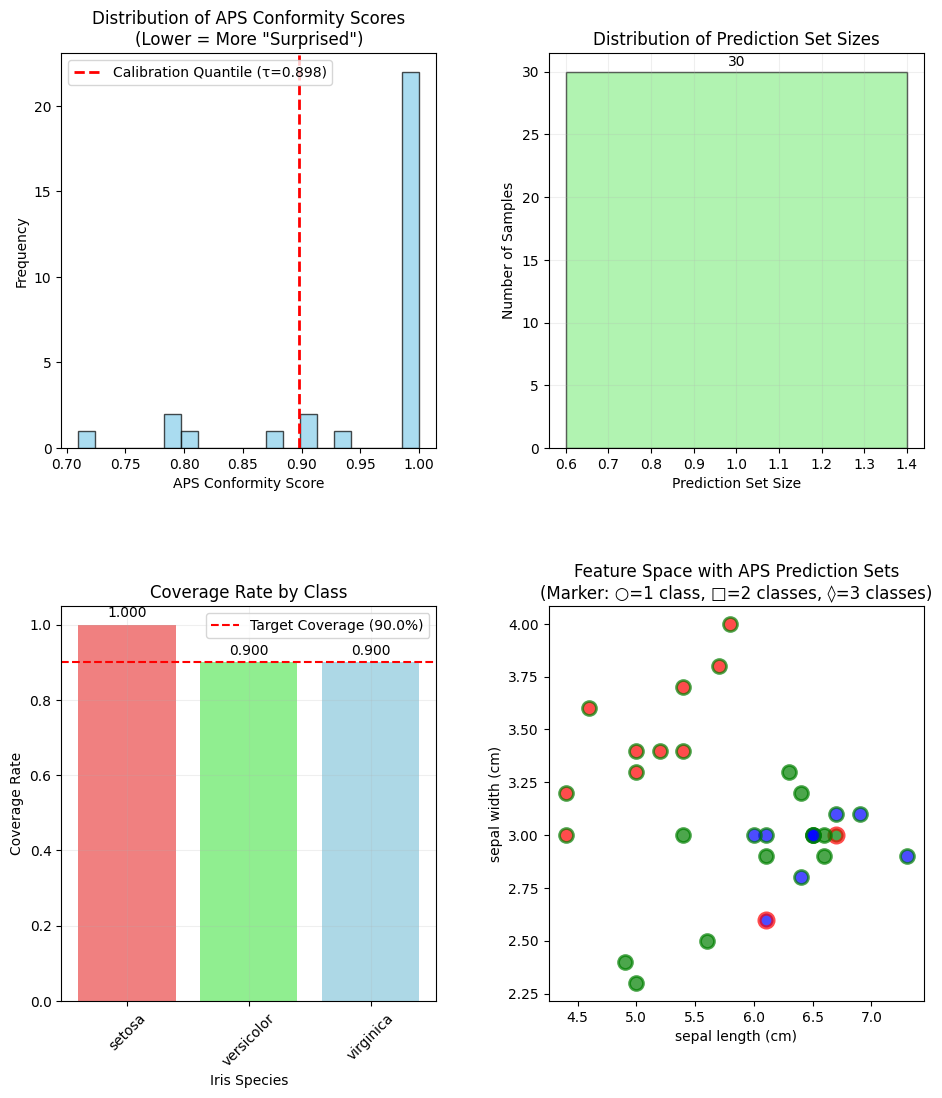

In [20]:
from typing import Any


def main() -> tuple[SplitConformalAPSImplementation, dict[str, float]]:
    """Main function to run APS on Iris dataset."""
    print("APS Implementation on Iris Dataset\n")

    # initialize APS system
    aps_system = SplitConformalAPSImplementation(significance_level=0.1)

    # load data
    x_train, x_calib, x_test, y_train, y_calib, y_test, feature_names, target_names = aps_system.load_prepare_data()

    print("Dataset Information:")
    print(f"  Features: {feature_names}")
    print(f"  Classes: {list(target_names)}")
    print(f"  Training samples: {x_train.shape[0]}")
    print(f"  Calibration samples: {x_calib.shape[0]}")
    print(f"  Test samples: {x_test.shape[0]}")

    # train and calibrate APS
    aps_system.fit(x_train, y_train, x_calib, y_calib)

    # evaluate APS
    results = aps_system.evaluate_aps(x_test, y_test)

    print("\nAPS Evaluation Results:")
    print(f"  Coverage rate: {results['coverage']:.3f}")
    print(f"  Average set size: {results['average_set_size']:.2f}")
    print(f"  Point prediction accuracy: {results['point_accuracy']:.3f}")

    # create visualization
    create_visualisation(aps_system, x_test, y_test, feature_names, target_names, results)

    return aps_system, results


if __name__ == "__main__":
    aps_system, results = main()

### APS with cross-validation+ (CV+)

Even though our first code uses an effective predictive algorithm, it could be even more accurate. What we couldn´t take into consideration was the set size of the training data since we also had to use a part for calibration and testing of our algorithm.
<br> To solve that we use a method called cross-validation (CV+), which allows us to use more of our overall dataset to increase the accuracy and robustness of our estimate ˆπ. This method is especially helpful for small datasets (like iris).
Cross-validation+ replaces our Split Conformal calibration so our data can get us a tighter prediction set. 

In [21]:
from sklearn.base import clone
from sklearn.model_selection import KFold


class CVPlusAPSImplementation(BaseAPSImplementation):
    """CV+ Implementation."""

    def __init__(
        self,
        significance_level: float = 0.1,
        n_folds: int = 5,
        model: RandomForestClassifier | None = None,
    ) -> None:
        """Initializes CV+ APS with given significance level and number of folds."""
        super().__init__(significance_level, model)
        self.n_folds = n_folds
        self.fold_models = []

    def fit(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> "CVPlusAPSImplementation":
        """CV+ uses all data for training and calibration."""
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        all_scores = []
        self.fold_models = []

        print(f"Training CV+ with {self.n_folds} Folds...")
        for fold, (train_idx, calib_idx) in enumerate(kf.split(x)):
            # train model on training fold
            model_fold = clone(self.model)
            model_fold.fit(x[train_idx], y[train_idx])
            self.fold_models.append(model_fold)

            # calculate conformity scores on calibration fold
            calib_probs = model_fold.predict_proba(x[calib_idx])
            fold_scores = self.aps_conformity_score(calib_probs, y[calib_idx])
            all_scores.extend(fold_scores)

            print(f"  Fold {fold + 1}: {len(train_idx)} Train, {len(calib_idx)} Calib")

        self.calibration_scores = np.array(all_scores)
        self.quantile = np.quantile(self.calibration_scores, self.significance_level)

        # train final model on all data for point predictions
        self.model.fit(x, y)

        print("\nCV+ calibration complete:")
        print(f"Calibration quantile: {self.quantile:.3f}")
        print(f"Target coverage: {1 - self.significance_level:.1%}")

        return self

    def predict(self, x: np.ndarray) -> tuple:
        """CV+ predictions with all fold models."""
        all_probabilities = []

        for model in self.fold_models:
            probs = model.predict_proba(x)
            all_probabilities.append(probs)

        # average probabilities across folds
        avg_probabilities = np.mean(all_probabilities, axis=0)
        point_predictions = np.argmax(avg_probabilities, axis=1)
        prediction_sets = self.calculate_prediction_sets(avg_probabilities, self.quantile)
        aps_scores = self.aps_conformity_score(avg_probabilities, point_predictions)

        return point_predictions, prediction_sets, aps_scores

In [22]:
print("CV+ APS test:")

# load data
base_aps = BaseAPSImplementation()
x_train, x_calib, x_test, y_train, y_calib, y_test, feature_names, target_names = base_aps.load_prepare_data()
x_combined = np.vstack([x_train, x_calib])
y_combined = np.concatenate([y_train, y_calib])

# test CV+ APS
cv_aps = CVPlusAPSImplementation(significance_level=0.1, n_folds=5)
cv_aps.fit(x_combined, y_combined)
cv_results = cv_aps.evaluate_aps(x_test, y_test)

print("\nCV+ APS:")
print(f"Coverage: {cv_results['coverage']:.3f}")
print(f"Average set size: {cv_results['average_set_size']:.2f}")
print(f"Point accuracy: {cv_results['point_accuracy']:.3f}")
print(f"Single-Prediction Rate: {cv_results['single_prediction_rate']:.3f}")

CV+ APS test:
Training CV+ with 5 Folds...
  Fold 1: 96 Train, 24 Calib
  Fold 2: 96 Train, 24 Calib
  Fold 3: 96 Train, 24 Calib
  Fold 4: 96 Train, 24 Calib
  Fold 5: 96 Train, 24 Calib

CV+ calibration complete:
Calibration quantile: 0.870
Target coverage: 90.0%

CV+ APS:
Coverage: 0.900
Average set size: 1.00
Point accuracy: 0.900
Single-Prediction Rate: 1.000


### Jackknife+

To ensure we maximize the utility of our dataset we could consider using all of our data, which one would think gets us a more accurate result. However giving all of the data to our model for training would mean that we have an overly confident model that isn´t giving us answers based on its training but rather based on its memory. 
<br> Since it won´t get "surprised" by the true class of a point it has memorized,, we will also have a deceptively small non-conformity score.(the measured error or residual).
If we rely on these overly small error scores, the prediction sets will be too narrow, causing the prediction's guaranteed coverage (e.g., 90% certainty) to fail. 

<br> To avoid something like that we have our method Jackknife+. This method efficiently solves this problem by following the Leave-One-Out construction to make our model independent. While it trains n seperate models, where n is the size of the calibration set, it leaves out one data point for each model. Now we have some data that the model has never seen before which can be used for testing. This ensures a much more stern coverage guarantee, a variability of the training data and a more honest non-conformity score.

In [23]:
class JackknifePlusAPS(BaseAPSImplementation):
    """Jackknife+ implementation for APS."""

    def __init__(
        self,
        significance_level: float = 0.1,
        model: RandomForestClassifier | None = None,
        max_samples: int | None = None,
    ) -> None:
        """Initializes Jackknife+ APS with given significance level and model."""
        super().__init__(significance_level)
        self.model = model or RandomForestClassifier(n_estimators=100, random_state=42)
        self.leave_one_out_models = []
        self.calibration_scores = None
        self.max_samples = max_samples

    def fit(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> "JackknifePlusAPS":
        """jacknife+ trains n models, each leaving one point out."""
        n_samples = len(x)
        all_scores = []
        self.leave_one_out_models = []

        for i in range(n_samples):
            # leave one out training
            train_idx = [j for j in range(n_samples) if j != i]

            model_loo = clone(self.model)
            model_loo.fit(x[train_idx], y[train_idx])
            self.leave_one_out_models.append(model_loo)

            # score for left-out point
            prob = model_loo.predict_proba(x[i].reshape(1, -1))[0]
            score = self.aps_conformity_score(prob.reshape(1, -1), np.array([y[i]]))[0]
            all_scores.append(score)

        self.calibration_scores = np.array(all_scores)
        self.quantile = np.quantile(self.calibration_scores, self.significance_level)

        # train final model on all data for point predictions
        self.model.fit(x, y)

        return self

    def predict(self, x: np.ndarray) -> tuple[np.ndarray, list[list[int]], np.ndarray]:
        """Jackknife+ Prediction with all LOO-models."""
        all_probabilities = []

        for model in self.leave_one_out_models:
            probs = model.predict_proba(x)
            all_probabilities.append(probs)

        # average probabilities over all LOO models
        avg_probabilities = np.mean(all_probabilities, axis=0)
        point_predictions = np.argmax(avg_probabilities, axis=1)
        prediction_sets = self.calculate_prediction_sets(avg_probabilities, self.quantile)
        aps_scores = self.aps_conformity_score(avg_probabilities, point_predictions)

        return point_predictions, prediction_sets, aps_scores

In [24]:
print("JACKKNIFE+ APS TEST:")

# load data
base_aps = BaseAPSImplementation()
X_train, X_calib, X_test, y_train, y_calib, y_test, feature_names, target_names = base_aps.load_prepare_data()
X_combined = np.vstack([X_train, X_calib])
y_combined = np.concatenate([y_train, y_calib])

# test Jackknife+ APS
jackknife_aps = JackknifePlusAPS(significance_level=0.1, max_samples=40)
jackknife_aps.fit(X_combined, y_combined)
jackknife_results = jackknife_aps.evaluate_aps(X_test, y_test)

print(f"\nCoverage: {jackknife_results['coverage']:.3f}")
print(f"Average set size: {jackknife_results['average_set_size']:.2f}")
print(f"Point accuracy: {jackknife_results['point_accuracy']:.3f}")
print(f"Single-Prediction Rate: {jackknife_results['single_prediction_rate']:.3f}")

JACKKNIFE+ APS TEST:

Coverage: 0.900
Average set size: 1.00
Point accuracy: 0.900
Single-Prediction Rate: 1.000


## Comparison

After having seen different approaches for our APS implementation we can conclude that each method has its advantages and disadvantages.

Let us take a look at each methods pro and cons:

### Split Conformal

**Advantages**:
-  Simple and efficient
-  Easy implementation
-  Provides valid coverage guarantees
-  Fast Prediction

**Disadvantages**:
-  Requires data splitting, reducing training data
-  May have higher variance in small dataset

### CV+

**Advantages**:
-  Better data utilization through cross-validation
-  More stable quantile estimation
-  Reduced variance compared to split conformal
-  Robust perofrmance

**Disadvantages**:
-  Computationally more expensive
-  More complex implementation
-  Longer training time

### Jackknife+

**Advantages**:
-  Strong theoritical guarantees
-  Most robust coverage properties
-  Good variance

**Disadvantages**:
-  Computationallyvery expensive
-  Impractical for large datasets
-  Often produces larger prediction sets

#### A toned down basic comparison:

In [27]:
# Comparison table of APS methods
basic_comparison = {
    "Method": ["Split Conformal", "CV+", "Jackknife+"],
    "Computational Cost": ["Low", "Medium", "Very High"],
    "Data Efficiency": ["Low", "High", "Highest"],
    "Recommended Dataset Size": ["> 10,000", "1,000 - 10,000", "< 1,000"],
    "Ease of Implementation": ["High", "Medium", "Low"],
}

basic_df = pd.DataFrame(basic_comparison)
print("BASIC APS METHODS COMPARISON")
print("=" * 129)
print(basic_df.to_string(index=False, col_space=25))
print("\n")

BASIC APS METHODS COMPARISON
                   Method        Computational Cost           Data Efficiency  Recommended Dataset Size    Ease of Implementation
          Split Conformal                       Low                       Low                  > 10,000                      High
                      CV+                    Medium                      High            1,000 - 10,000                    Medium
               Jackknife+                 Very High                   Highest                   < 1,000                       Low




#### Comparison of their performances 

In [28]:
# performance comparison in general
methods = ["Split Conformal", "CV+", "Jackknife+"]
coverages = [split_results["coverage"], cv_results["coverage"], jackknife_results["coverage"]]
set_sizes = [split_results["average_set_size"], cv_results["average_set_size"], jackknife_results["average_set_size"]]
accuracies = [split_results["point_accuracy"], cv_results["point_accuracy"], jackknife_results["point_accuracy"]]

print("\nMETHOD COMPARISON:")
print("Method           | Coverage | Avg Set Size | Accuracy")
print("-" * 50)
for i, method in enumerate(methods):
    print(f"{method:<16} | {coverages[i]:.3f}    | {set_sizes[i]:.2f}         | {accuracies[i]:.3f}")

# performance summary on Iris dataset
performance_data = {
    "Method": ["Split Conformal", "CV+", "Jackknife+"],
    "Coverage": [
        f"{split_results['coverage']:.3f}",
        f"{cv_results['coverage']:.3f}",
        f"{jackknife_results['coverage']:.3f}",
    ],
    "Average Set Size": [
        f"{split_results['average_set_size']:.2f}",
        f"{cv_results['average_set_size']:.2f}",
        f"{jackknife_results['average_set_size']:.2f}",
    ],
    "Point Accuracy": [
        f"{split_results['point_accuracy']:.3f}",
        f"{cv_results['point_accuracy']:.3f}",
        f"{jackknife_results['point_accuracy']:.3f}",
    ],
    "Single-Prediction Rate": [
        f"{split_results['single_prediction_rate']:.3f}",
        f"{cv_results['single_prediction_rate']:.3f}",
        f"{jackknife_results['single_prediction_rate']:.3f}",
    ],
}

performance_df = pd.DataFrame(performance_data)
print("\nPERFORMANCE COMPARISON ON IRIS DATASET")
print("=" * 80)
print(performance_df.to_string(index=False))


METHOD COMPARISON:
Method           | Coverage | Avg Set Size | Accuracy
--------------------------------------------------
Split Conformal  | 0.933    | 1.00         | 0.933
CV+              | 0.900    | 1.00         | 0.900
Jackknife+       | 0.900    | 1.00         | 0.900

PERFORMANCE COMPARISON ON IRIS DATASET
         Method Coverage Average Set Size Point Accuracy Single-Prediction Rate
Split Conformal    0.933             1.00          0.933                  1.000
            CV+    0.900             1.00          0.900                  1.000
     Jackknife+    0.900             1.00          0.900                  1.000


All three APS methods achieve their target 90% coverage on the Iris dataset. **Split Conformal slightly exceeds the target 93.3%**, while **CV+ and Jackknife+ achieve exact 90% coverage**.

All methods **maintain perfect single-class predictions** (set size= 1.00) with **high accuracy**, demonstrating effective uncertainty quantification while **preserving prediction efficientcy**. 

## Conclusion

Adaptive Predictions Sets successfully bridge the gap between point predicion and reliable uncertainy quantification. All three methods (Split Conformal, CV+, Jackknife+) deliver **guaranteed 90% coverage** while maintaining **efficient single-class predictions** on the Iris dataset.

Split Conformal proves most practival with strong performance and minimal overhead, while CV+ offers better data utilzation for medium datasets and Jackknife+ provides maximum reliabiity for critical applications.

This framework enables trustworthy AI deployment in high-stakes domain by b**lackbox predictions into statistically quaranteed confidence sets**,ensurering models **communicate their uncertainty** alongside their predictions. 



# Implementation in Probly

An implementation in Probly could look like this:

In [ ]:
import numpy as np


def calculate_quantile(scores: np.ndarray, alpha: float) -> float:
    """Calculate the quantile for conformal prediction.

    Parameters:
    scores : np.ndarray
            Non-conformity scores
    alpha : float
            Significance level (target coverage is 1-alpha)

    Returns:
    float (The (1-alpha)-quantile of the scores)
    """
    n = len(scores)
    q_level = np.ceil((n + 1) * (1 - alpha)) / n
    q_level = min(q_level, 1.0)  # ensure within [0, 1]
    return float(np.quantile(scores, q_level, method="lower"))


def calculate_nonconformity_score(
    probabilities: np.ndarray,
    labels: np.ndarray,
) -> np.ndarray:
    """Calculate APS non-conformity scores for given true labels.

    Parameters:
    probabilities : np.ndarray
        Predicted probabilities of shape (n_samples, n_classes)
    labels : np.ndarray
        True labels of shape (n_samples)

    Returns:
    np.ndarray
        Non-conformity scores of shape (n_samples)
    """
    n_samples = probabilities.shape[0]
    scores = np.zeros(n_samples)

    for i in range(n_samples):
        probs = probabilities[i]
        sorted_items = sorted([(-probs[j], j) for j in range(len(probs))])
        # Get descending sorted probabilities
        sorted_indices = [idx for (_, idx) in sorted_items]
        sorted_probs = probs[sorted_indices]
        cumulative_probs = np.cumsum(sorted_probs)

        # find pos of true label in sorted order
        # will fail if labels[i] is out of bounds, but is expected
        true_label_pos = sorted_indices.index(labels[i])
        scores[i] = cumulative_probs[true_label_pos].item()

    return scores

To give an explanation of the code:

#### 1. `calculate_quantile()`



 --> *computes the calibrated APS threshold*
 
To do that, APS computes the $(1-\alpha)$-quantile of the calibration non-conformity scores.

This function :

- takes the vecotr of non-conformity scores
- computes the proper quantile using the standard formula $\lceil(n + 1)(1 - \alpha)\rceil$
- ensures the quantile level stays in [0,1]
- return the correspinding value via `np.quantile`






#### 2. `calculate_nonconformity_score()`

--> *computes the APS non-conformity scores*

$$ E(x,y,\hat{\pi}) = cumulative \ probability \ up \ to \ the \ true \ class $$

For each sample:
- the predicted class probabilites are **sorted in descending order.**
- The true label's postion in that rankind is identified.
- The **cumulative probability** up to that index is computed.
- This cumulative probability up to that index is computed.



These functions implement the mathematical foundation of APS and are reused across different conformal prediction methods.
